# Which version of the website should you use?

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 💾 The data
The team assembled the following file:

#### Redesign test data
- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

## 💪 Challenge
Complete the following tasks:

1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.
2. Can the increases observed be explained by randomness? (Hint: Think A/B test)
3. Which version of the website should they use?

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

%matplotlib inline
sns.set_style('whitegrid')

df = pd.read_csv('redesign.csv')
df

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0
...,...,...,...
40479,no,no,0
40480,yes,yes,0
40481,yes,yes,0
40482,no,no,0


Find conversion in each of the 4 groups using a pivot table. The convenience of using 0 and 1 is that it is enough to apply **mean()** function to calculate metrics.

In [101]:
df.pivot_table(columns='new_images', index='treatment', values='converted', aggfunc='mean')


new_images,no,yes
treatment,,
no,0.107104,0.112538
yes,0.120047,0.113724


We can see that all versions have better conversion than in group in which there were no any changes. But this difference may be caused by randomness. We should draw confidence intervals and comare them.  
Separate our dataset on 4 groups: 
 
$Control$ - no any changes  
$A$ - new landing page and old set of images  
$B$ - past page and new images  
$C$ - all *'variables'* are new  

In [102]:
control_group = df.query("treatment == 'no' & new_images == 'no'")['converted'] # No changes
A_group = df.query("treatment == 'yes' & new_images == 'no'")['converted'] # New landing, old images
B_group = df.query("treatment == 'no' & new_images == 'yes'")['converted'] # Old landing, new images
C_group = df.query("treatment == 'yes' & new_images == 'yes'")['converted'] # New landing, new images
print(len(control_group), len(A_group), len(B_group), len(C_group))

10121 10121 10121 10121


All groups have equal count of rows. So we don't need to take care about the size of the samples.  
Now we should draw confidence intervals. Do it with bootstrap. I will use simple function:

In [103]:
def bootstrap(data, func, n):
    bs_values = np.empty(n)
    for i in range(n):
        bs_values[i] = func(np.random.choice(data, len(data)))
    return bs_values

Apply this func to each group:

In [104]:
bs_control = bootstrap(control_group, np.mean, 10000)
bs_A = bootstrap(A_group, np.mean, 10000)
bs_B = bootstrap(B_group, np.mean, 10000)
bs_C = bootstrap(C_group, np.mean, 10000)

Remember *CR* in every group:

In [105]:
print('Control group conversion =', control_group.mean(), '\n' + 'A - group conversion =', A_group.mean(),
      '\n' + 'B - group conversion =', B_group.mean(), '\n' + 'C - group conversion =', C_group.mean())

Control group conversion = 0.10710404110265784 
A - group conversion = 0.12004742614366169 
B - group conversion = 0.11253828673056022 
C - group conversion = 0.11372394032210256


And find 95% intervals:

In [106]:
print('Control group 95% confidence interval =', np.percentile(bs_control, q=[2.5, 97.5]))
print('A - group 95% confidence interval =', np.percentile(bs_A, q=[2.5, 97.5]))
print('B - group 95% confidence interval =', np.percentile(bs_B, q=[2.5, 97.5]))
print('C - group 95% confidence interval =', np.percentile(bs_C, q=[2.5, 97.5]))

Control group 95% confidence interval = [0.10097816 0.11322992]
A - group 95% confidence interval = [0.11372394 0.12637091]
B - group 95% confidence interval = [0.10641241 0.11876297]
C - group 95% confidence interval = [0.10759806 0.12004743]


The mean of groups $A$ and $C$ aren't in the confidence interval of the $control$ group. But intervals of group $C$ and $control$ group intersect. It means that difference between them isn't so high.  
Better way to find solution is visualisation. Build a histogram of means of every group:

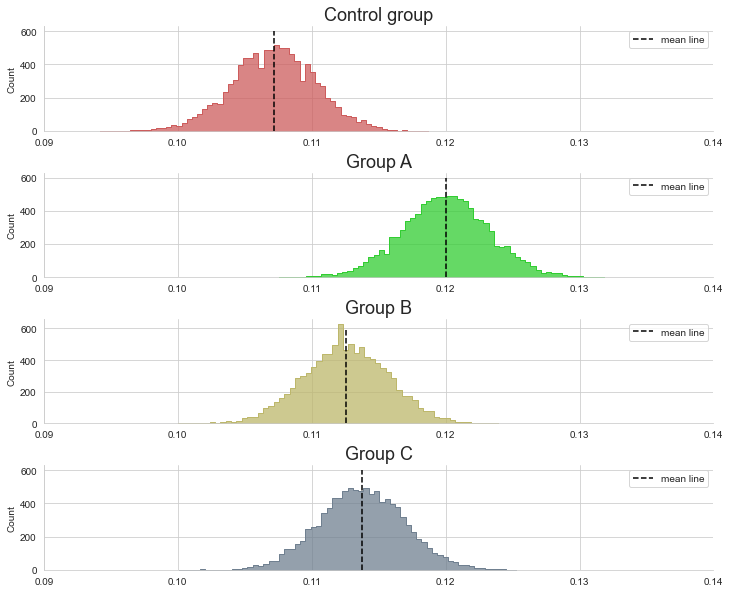

In [122]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10))
groups = [bs_control, bs_A, bs_B, bs_C]
group_names = ['Control group', 'Group A', 'Group B', 'Group C']
colors = ['indianred', 'limegreen', 'darkkhaki', 'slategrey']

for i in range(len(groups)):
    sns.histplot(groups[i], ax=ax[i], element="step", color=colors[i])
    ax[i].set_xlim(0.09, 0.14)
    ax[i].set_title(group_names[i], fontsize = 18)
    ax[i].vlines(groups[i].mean(), 0, 600, color='black', linestyle = '--', label='mean line')
    ax[i].set_label(i)
    ax[i].legend()
plt.subplots_adjust(hspace=0.4)
sns.despine()


Groups $B$ and $C$ don't differ much from each other. Plus we concluded that the differences between $B$ and $control$ group are not significant. At the same time, the average of group $A$ is so far from other groups. With high chance changes in $A$ group *(new landing page and default images)* led to increase of conversion.  
Our samples have a normal distribution, so we can use a **t-test** to check the static significance with α = 0.05:

In [108]:
print(f"Control group - group A: p-value = {round(ss.ttest_ind(control_group, A_group)[1], 4)}")
print(f"Control group - group B: p-value = {round(ss.ttest_ind(control_group, B_group)[1], 4)}")
print(f"Control group - group C: p-value = {round(ss.ttest_ind(control_group, C_group)[1], 4)}")

Control group - group A: p-value = 0.0037
Control group - group B: p-value = 0.2163
Control group - group C: p-value = 0.133


Only $A$ group has a p - value > 0.05. This means that the new version of landing page has really increased the conversion rate. But adding images increased the CR for one users group and reduced this for another.  
  
*Conclusion: it is necessary to change the landing page on the site and leave old set of images.*